In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### Bivariate Normal Data Generation

In [3]:
MU = {
    1: [1,1],
    2: [4,3],
    3: [2,6],
    4: [7,4]
}

COV = {
    1: np.eye(2)*0.05,
    2: np.eye(2)*0.05,
    3: np.eye(2)*0.05,
    4: np.eye(2)*0.05
}

N_SAMPLERS = 4
SAMPLERS = {}
for idx in range(1, N_SAMPLERS+1, 1):
    SAMPLERS[idx] = N(MU[idx], COV[idx])

In [4]:
n = 1000
X_TRAIN, Y_TRAIN = {}, {}
X_TEST, Y_TEST = {}, {}

for cls in SAMPLERS:
    X_TRAIN[cls] = SAMPLERS[cls].sample(n)
    Y_TRAIN[cls] = np.array([cls]*n)
    X_TEST[cls] = SAMPLERS[cls].sample(n)
    Y_TEST[cls] = np.array([cls]*n)

# Dataset
def cls_to_dset(idxs, X, Y):
    x, y = [], []
    for idx in idxs:
        x.extend(X[idx])
        y.extend(Y[idx])
    x = np.array(x)
    y = np.array(y)
    return list(zip(x, y)), x, y

IND_CLS = [1, 2, 3]
OOD_CLS = [4]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)


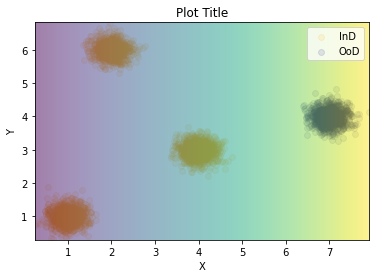

In [5]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.10)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.10)
xi = np.linspace(0, 8, 100, endpoint=True)
yi = np.linspace(0, 8, 100, endpoint=True)
# xy_pos = list(product(x_pos, y_pos))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=300
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
plt.pcolormesh(xi, yi, xi, shading='auto', alpha=0.50)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### Naive Classifier Training

In [17]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configguration
max_epoch = 64
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch)

  5%|▍         | 3/64 [00:00<00:05, 11.14it/s]

Epoch  # 1 | Tri loss: 0.9567                     | Tri accuracy: 0.5866
Epoch  # 1 | Val loss: 0.8274                     | Val accuracy: 0.6684


 20%|██        | 13/64 [00:00<00:03, 16.88it/s]

Epoch  # 11 | Tri loss: 0.0096                     | Tri accuracy: 1.0
Epoch  # 11 | Val loss: 0.0076                     | Val accuracy: 1.0


 39%|███▉      | 25/64 [00:01<00:01, 21.57it/s]

Epoch  # 21 | Tri loss: 0.0009                     | Tri accuracy: 1.0
Epoch  # 21 | Val loss: 0.0008                     | Val accuracy: 1.0


 53%|█████▎    | 34/64 [00:01<00:01, 22.78it/s]

Epoch  # 31 | Tri loss: 0.0003                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.0003                     | Val accuracy: 1.0


 67%|██████▋   | 43/64 [00:02<00:00, 21.76it/s]

Epoch  # 41 | Tri loss: 0.0002                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.0002                     | Val accuracy: 1.0


 81%|████████▏ | 52/64 [00:02<00:00, 18.75it/s]

Epoch  # 51 | Tri loss: 0.0001                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0001                     | Val accuracy: 1.0


100%|██████████| 64/64 [00:03<00:00, 19.00it/s]

Epoch  # 61 | Tri loss: 0.0001                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0001                     | Val accuracy: 1.0


#### Plot

[autoreload of simulation failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framewor

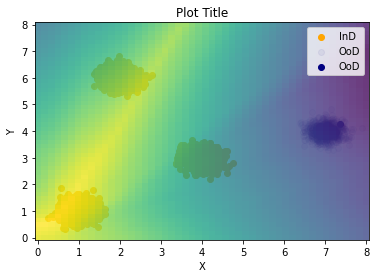

In [57]:
from simulation import *
D = DSIM()
plot_heatmap(IND_X, OOD_X, OOD_BATCH, D)

torch.Size([2500, 3])


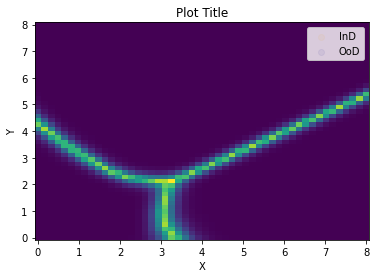

In [18]:
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=50
# xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)

# zi = torch.softmax(D(torch.tensor(np.vstack([xi.flatten(), yi.flatten()]).T, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)), shading='auto', alpha=1)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### WOOD Training

In [53]:
from simulation import *
D_WOOD = DSIM()
# OOD data preparation
n_ood = 4
ood_bsz = 4
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([4, 2])


  2%|▏         | 1/64 [00:00<00:43,  1.45it/s]

Epoch  # 1 | Tri loss: 0.907                     | Tri accuracy: 0.3997
Epoch  # 1 | Val loss: 0.8778                     | Val accuracy: 0.4093


 17%|█▋        | 11/64 [00:06<00:30,  1.74it/s]

Epoch  # 11 | Tri loss: 0.3314                     | Tri accuracy: 0.9867
Epoch  # 11 | Val loss: 0.3613                     | Val accuracy: 0.9912


 33%|███▎      | 21/64 [00:12<00:23,  1.85it/s]

Epoch  # 21 | Tri loss: 0.2223                     | Tri accuracy: 0.999
Epoch  # 21 | Val loss: 0.2588                     | Val accuracy: 0.9997


 48%|████▊     | 31/64 [00:17<00:18,  1.77it/s]

Epoch  # 31 | Tri loss: 0.1389                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.1718                     | Val accuracy: 1.0


 64%|██████▍   | 41/64 [00:23<00:11,  1.93it/s]

Epoch  # 41 | Tri loss: 0.0855                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.121                     | Val accuracy: 1.0


 80%|███████▉  | 51/64 [00:28<00:07,  1.74it/s]

Epoch  # 51 | Tri loss: 0.0601                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0975                     | Val accuracy: 1.0


 95%|█████████▌| 61/64 [00:33<00:01,  2.02it/s]

Epoch  # 61 | Tri loss: 0.0466                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0823                     | Val accuracy: 1.0


100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


torch.Size([2500, 3])


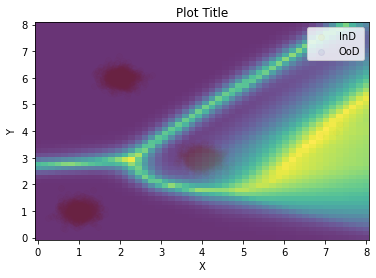

In [54]:
# 4
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

torch.Size([2500, 3])


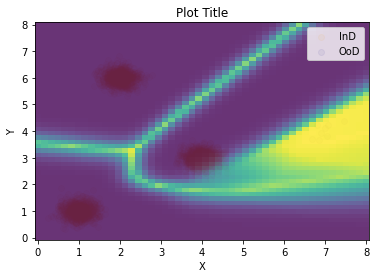

In [49]:
# 8
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

torch.Size([2500, 3])


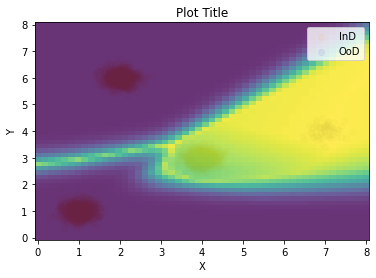

In [42]:
# 64
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

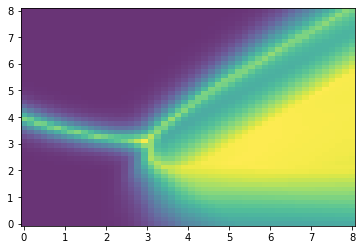

In [26]:
# 1000
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)

### OOD GAN Training

In [59]:
from simulation import *
# D_GAN = DSIM()
# G_GAN = GSIM()
# OOD data preparation
n_ood = 64
ood_bsz = 64
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
w_ce, w_wass = 1, 0.1
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, \
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([4, 2])


  8%|▊         | 1/12 [00:01<00:14,  1.36s/it]

Step: 0    | D:  0.4638 | CE:  0.4630 | W_OoD:  0.9558 | W_z:  0.9354 | G:  0.0388 | W_z:  0.9465


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


Epoch  # 1 | Val accuracy: 0.998


 42%|████▏     | 5/12 [00:05<00:07,  1.10s/it]

Step: 4    | D:  0.3695 | CE:  0.3688 | W_OoD:  0.9522 | W_z:  0.9350 | G:  0.0392 | W_z:  0.9363


100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Epoch  # 11 | Val accuracy: 0.9992


 75%|███████▌  | 9/12 [00:09<00:03,  1.10s/it]

Step: 8    | D:  0.2521 | CE:  0.2514 | W_OoD:  0.9507 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9349


100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Epoch  # 21 | Val accuracy: 0.9997


  8%|▊         | 1/12 [00:01<00:11,  1.08s/it]

Step: 0    | D:  0.2029 | CE:  0.2023 | W_OoD:  0.9521 | W_z:  0.9367 | G:  0.0392 | W_z:  0.9365


100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Epoch  # 31 | Val accuracy: 0.9997


 42%|████▏     | 5/12 [00:07<00:10,  1.45s/it]

Step: 4    | D:  0.1583 | CE:  0.1578 | W_OoD:  0.9478 | W_z:  0.9346 | G:  0.0392 | W_z:  0.9364


100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Epoch  # 41 | Val accuracy: 0.9997


 75%|███████▌  | 9/12 [00:10<00:03,  1.18s/it]

Step: 8    | D:  0.0956 | CE:  0.0951 | W_OoD:  0.9470 | W_z:  0.9354 | G:  0.0393 | W_z:  0.9350


  8%|▊         | 1/12 [00:01<00:13,  1.20s/it]

Step: 0    | D:  0.0982 | CE:  0.0977 | W_OoD:  0.9482 | W_z:  0.9363 | G:  0.0392 | W_z:  0.9355


100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Epoch  # 51 | Val accuracy: 0.9997


 42%|████▏     | 5/12 [00:05<00:08,  1.19s/it]

Step: 4    | D:  0.0751 | CE:  0.0740 | W_OoD:  0.9631 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9342


100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Epoch  # 61 | Val accuracy: 0.9997


100%|██████████| 12/12 [00:15<00:00,  1.26s/it]


torch.Size([2500, 3])


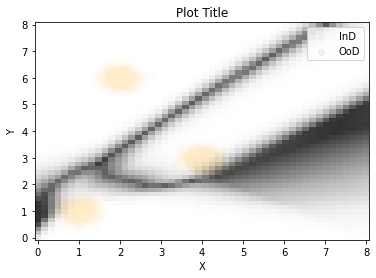

In [60]:
# 4
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8, cmap='binary')
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

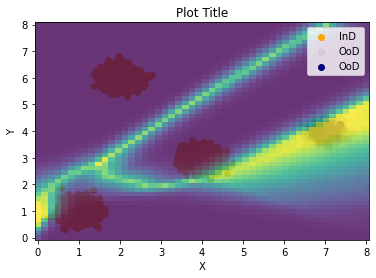

In [61]:
plot_heatmap(IND_X, OOD_X, OOD_BATCH, D_GAN)

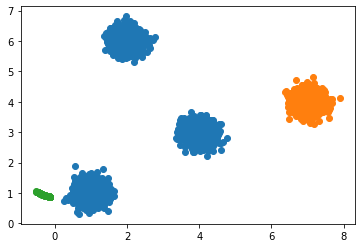

In [75]:
seed = torch.rand((128, 1))
gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0], IND_X[:,1])
plt.scatter(OOD_X[:,0], OOD_X[:,1])
plt.scatter(gz[:,0], gz[:,1])
plt.show()

torch.Size([2500, 3])


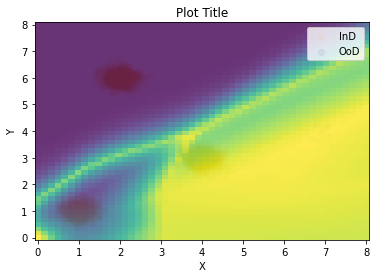

In [52]:
# 8
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

torch.Size([2500, 3])


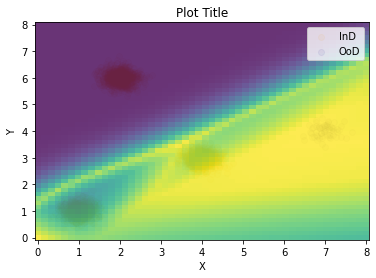

In [47]:
# 64
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [76]:
z = torch.softmax(D_GAN(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
print(z.shape)
s = ood_wass_loss(z)
print(s.shape)

torch.Size([3000, 3])
torch.Size([3000])


In [81]:
threshold = np.quantile(s, 0.95)
print(threshold)
z_ood = torch.softmax(D_GAN(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
print(z_ood.shape)
s_ood = ood_wass_loss(z_ood)

0.05233897697180509
torch.Size([1000, 3])


In [82]:
tpr = sum(s_ood > threshold) / len(s_ood)
print(tpr)

tensor(0.9990)


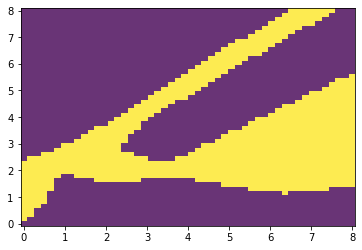

In [83]:
mask = si > threshold
plt.pcolormesh(xi, yi, mask.reshape((50,50)).T, shading='auto', alpha=0.8)